## Constrainted Generation Analysis

### Load Results

In [1]:
cd ../..

/Users/YRZ/p-extreme-text


In [2]:
from pathlib import Path
from typing import Any, Dict, List
import dill

with open("data/all_data.dill", "rb") as f:
    all_data: Dict[str, List[Dict[str, Any]]] = dill.load(f)
    
data_names = list(all_data.keys())
data_names = sorted(data_names, key=lambda x: (x.split('_')[1], x.split('_')[0]))

data_sizes = [len(all_data[k]) for k in data_names]

In [3]:
model_names = {
    "zeroshot-gpt4": "gpt-4-20trial-prompt",
    "zeroshot-gpt3.5": "gpt-3.5-turbo-20trial-prompt",
    "zeroshot-palm": "palm-text-bison-001-20trial-prompt",
    "zeroshot-vicuna7b": [f"vicuna-7b-1trial-no{i}-prompt" for i in range(5)],
    "zeroshot-alpaca7b": [f"alpaca-7b-1trial-no{i}-prompt" for i in range(5)],
}

model_prefix = {
    "zeroshot-gpt4": "GPT-4",
    "zeroshot-gpt3.5": "GPT-3.5",
    "zeroshot-palm": "PaLM",
    "zeroshot-vicuna7b": "Vicuna-7B",
    "zeroshot-alpaca7b": "Alpaca-7B",
}

In [4]:
import json
import numpy as np

trials, prompts, texts, prompt2text, promt_types = {}, {}, {}, {}, {}
trial_names = model_names.keys()
for mn in trial_names:
    if isinstance(model_names[mn], str):
        trials[mn] = json.load(open(f'logs/{model_names[mn]}.json'))
    elif isinstance(model_names[mn], list):
        for sub_names in model_names[mn]:
            sub = json.load(open(f'logs/{sub_names}.json'))
            if mn in trials.keys():
                if len(sub['texts']) < len(sub['prompts']):
                    truncate_n = len(sub['texts'])
                    trials[mn]['prompts'] += sub['prompts'][:truncate_n]
                    trials[mn]['texts'] += sub['texts'][:truncate_n]
                else:
                    trials[mn]['prompts'] += list(sub['prompts'])
                    trials[mn]['texts'] += list(sub['texts'])
            else:
                if len(sub['texts']) < len(sub['prompts']):
                    truncate_n = len(sub['texts'])
                    trials[mn] = {}
                    trials[mn]['prompts'] = sub['prompts'][:truncate_n]
                    trials[mn]['texts'] = sub['texts'][:truncate_n]
                else:
                    trials[mn] = sub
    promt_types[mn] = "oneshot_prompt" if "oneshot" in mn else "prompt"

for tn in trial_names:
    prompts[tn] = trials[tn]['prompts']
    texts[tn] = trials[tn]['texts']
    prompt2text[tn] = np.array(list(zip(prompts[tn], texts[tn])))
    
def sanity_check(k, c, example):
    # make sure example pass check
    assert c.check(example['example'], example['targets']), (k, example)
        
        
def value_check(k, c, example, text):
    return c.check(text, example['targets'])

for tn in trial_names:
    for k in data_names:
        grouped_k = k.split('_')[1]
        for eid, example in enumerate(all_data[k]):
            c = example['constraint']
            sanity_check(k, c, example)

            # load multiple trail results
            try:
                all_text = list(prompt2text[tn][:, 1][
                                prompt2text[tn][:, 0] == example[promt_types[tn]]
                            ].reshape(-1))
                # if None in all_text:
                #     print("Text is None - ", tn, k, example[promt_types[tn]], "/n")
                all_text = [x for x in all_text if x is not None]
                assert len(all_text) > 0
                all_res = [value_check(k, c, example, text) for text in all_text]
                all_data[k][eid][tn+"-all_text"] = all_text
                all_data[k][eid][tn+"-all_check_result"] = all_res
            except:
                # missing
                print("No text - ", tn, k, f"\nprompt:\n{example[promt_types[tn]]}\n\n")
                all_data[k][eid][tn+"-all_text"] = []
                all_data[k][eid][tn+"-all_check_result"] = []

No text -  zeroshot-palm ccnews_c05 
prompt:
Please generate a sentence:
1) with exactly 19 words;
2) with the 4th, 8th, 11th words to be 'suspect', 'home', 'hospital' respectively.


No text -  zeroshot-palm guten_c05 
prompt:
Please generate a sentence:
1) with exactly 11 words;
2) with the 4th, 8th, 11th words to be 'his', 'on', 'sore' respectively.


No text -  zeroshot-palm ccnews_c07 
prompt:
Please generate a sentence containing the word 'charged', 'been', 'Father'.


No text -  zeroshot-palm guten_c12 
prompt:
Please generate a paragraph:
1) with exactly 4 sentences;
2) with sentences having the last word to be 'walk', 'tumbling', 'another', 'lunatic', respectively.


No text -  zeroshot-palm ccnews_c14 
prompt:
Please generate a passage:
1) with paragraphs having the last sentence to be 'As you discovered in the above section, mice reproduce quickly and your problem can escalate over the course of months', 'Their urine can cause allergies in children, they can transmit human d

In [5]:
grouped_data_names = sorted(np.unique([k.split("_")[1] for k in data_names]))

grouped_data = {k: [] for k in grouped_data_names}
grouped_n_data_sets = {k: 0 for k in grouped_data_names}
for k in data_names:
    grouped_data[k.split("_")[1]] += all_data[k]
    grouped_n_data_sets[k.split("_")[1]] += 1
    
grouped_data_sizes = [len(grouped_data[k]) for k in grouped_data_names]

In [6]:
import matplotlib.pyplot as plt

In [7]:
rename_dict = {
        'c01': 'word01',
        'c02': 'word02',
        'c03': 'word03',
        'c04': 'sent01',
        'c05': 'sent02',
        'c06a': 'sent03',
        'c07': 'sent04',
        'c08': 'para01',
        'c09': 'para02',
        'c10': 'para03',
        'c11': 'para04',
        'c12': 'para05',
        'c14': 'pass01'
    }

def rename(data_k):
    if isinstance(data_k, str):
        for k in rename_dict.keys():
            if k in data_k:
                return data_k.replace(k, rename_dict[k])
    elif isinstance(data_k, list):
        res = []
        for data_k_ in data_k:
            for k in rename_dict.keys():
                if k in data_k_:
                    res.append(data_k_.replace(k, rename_dict[k]))
        return res
    else:
        return data_k

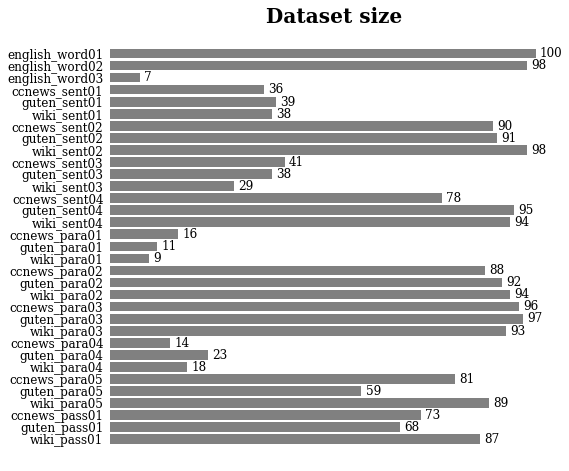

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.barh(rename(data_names[::-1]), data_sizes[::-1], color='gray')
for i, v in enumerate(data_sizes[::-1]):
    ax.text(v + 1, i, str(v), va='center', font='Serif', fontsize=12)

plt.box(False)
plt.tick_params(left=False, bottom=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_title('Dataset size', fontweight='bold', font='Serif', fontsize=20)
plt.yticks(font='Serif', fontsize=12)

plt.savefig('figures/dataset-size.pdf', bbox_inches='tight')

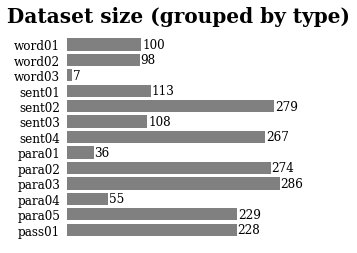

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.barh(rename(grouped_data_names[::-1]), grouped_data_sizes[::-1], color='gray')
for i, v in enumerate(grouped_data_sizes[::-1]):
    ax.text(v + 1, i, str(v), va='center', font='Serif', fontsize=12)

plt.box(False)
plt.tick_params(left=False, bottom=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_title('Dataset size (grouped by type)', fontweight='bold', font='Serif', fontsize=20)
plt.yticks(font='Serif', fontsize=12)

plt.savefig('figures/grouped-dataset-size.pdf', bbox_inches='tight')

In [28]:
def flatten_list(nested_list):
    flattened = []
    for i in nested_list:
        if isinstance(i, list):
            flattened.extend(flatten_list(i))
        else:
            flattened.append(i)
    return flattened

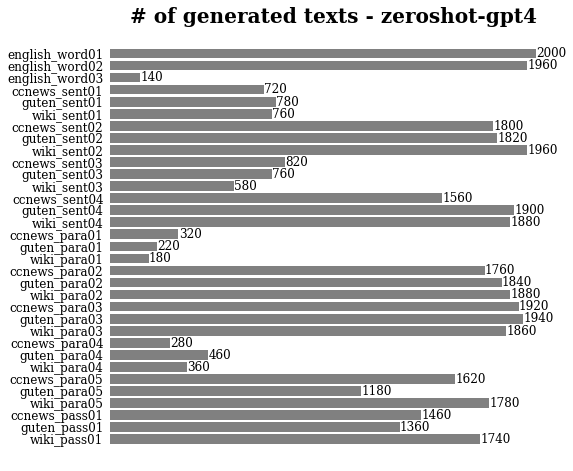

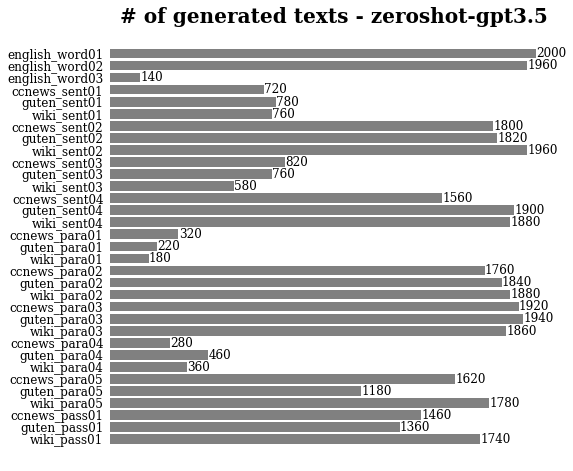

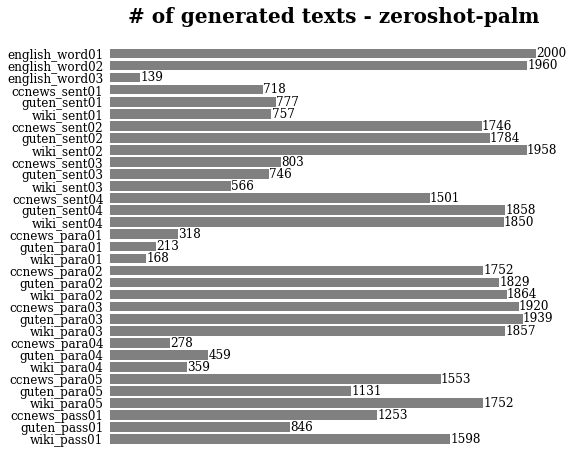

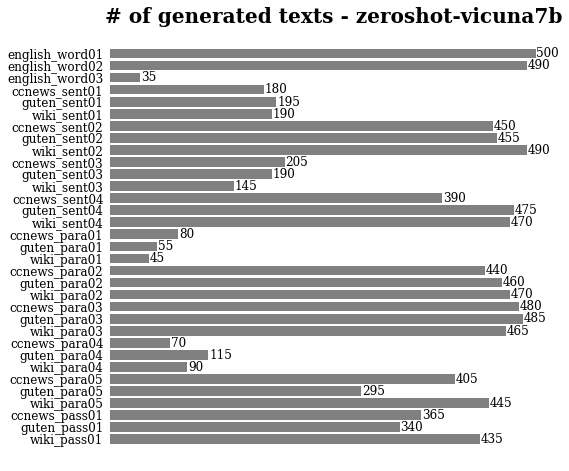

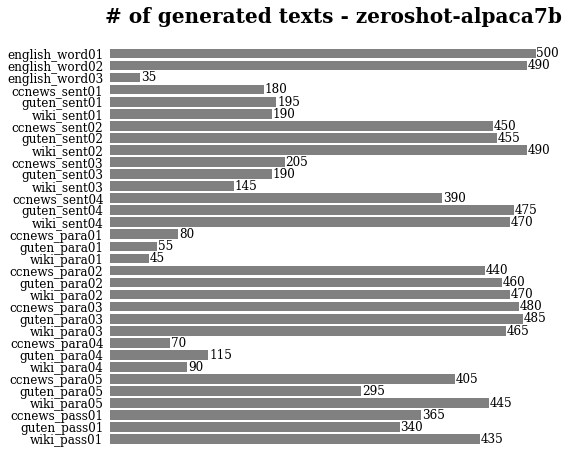

In [29]:
for tn in trial_names:
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    num_predictions = [len(flatten_list([e[tn+"-all_check_result"] for e in all_data[k]])) for k in data_names]

    ax.barh(rename(data_names[::-1]), num_predictions[::-1], color='gray')
    for i, v in enumerate(num_predictions[::-1]):
        ax.text(v + 1, i, str(v), va='center', font='Serif', fontsize=12)

    plt.box(False)
    plt.tick_params(left=False, bottom=False, labelbottom=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    ax.set_title(f'# of generated texts - {tn}', fontweight='bold', font='Serif', fontsize=20)
    plt.yticks(font='Serif', fontsize=12)

    plt.savefig(f'figures/num-predictions-{tn}.pdf', bbox_inches='tight')

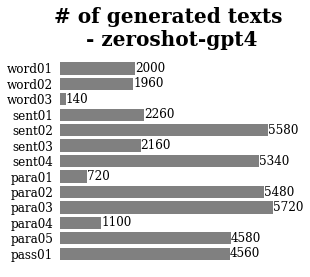

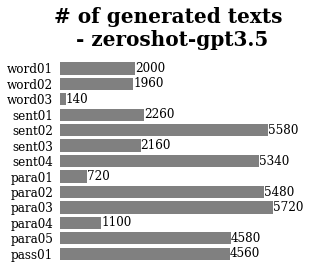

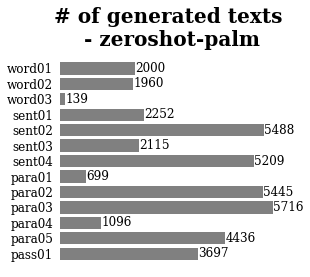

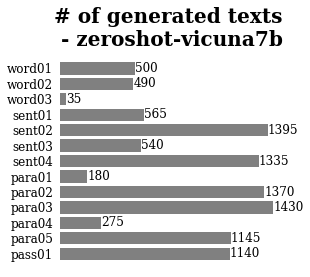

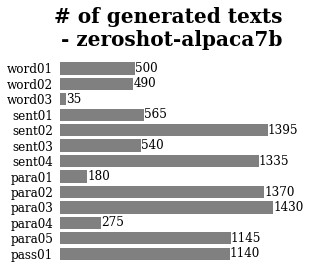

In [32]:
for tn in trial_names:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))

    num_predictions = [len(flatten_list([e[tn+"-all_check_result"] for e in grouped_data[k]])) for k in grouped_data_names]

    ax.barh(rename(grouped_data_names[::-1]), num_predictions[::-1], color='gray')
    for i, v in enumerate(num_predictions[::-1]):
        ax.text(v + 1, i, str(v), va='center', font='Serif', fontsize=12)

    plt.box(False)
    plt.tick_params(left=False, bottom=False, labelbottom=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    ax.set_title(f'# of generated texts \n- {tn}', fontweight='bold', font='Serif', fontsize=20)
    plt.yticks(font='Serif', fontsize=12)

    plt.savefig(f'figures/num-predictions-grouped-{tn}.pdf', bbox_inches='tight')

### Accuracy Overview

In [33]:
def accuracy_and_se(check_res):
    num_predictions = len(check_res)
    num_correct = sum(check_res)
    accuracy = num_correct / num_predictions
    standard_error = np.sqrt((accuracy * (1 - accuracy)) / num_predictions)
    
    return accuracy, standard_error, num_predictions

In [34]:
accuracy_report = {}
for tn in trial_names:
    accuracy_report[tn] = {k: accuracy_and_se(flatten_list([e[tn+"-all_check_result"] for e in all_data[k]])) for k in data_names}

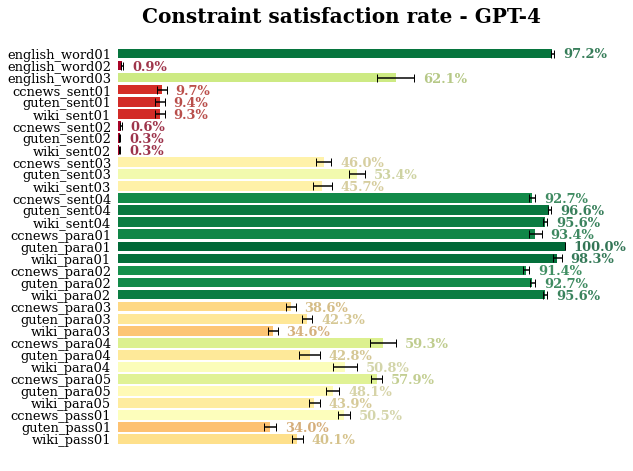

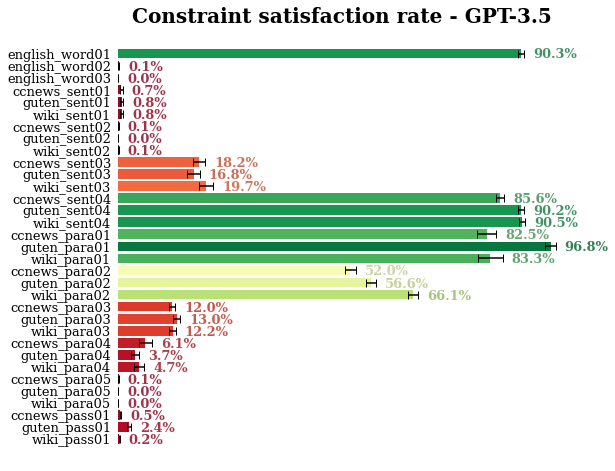

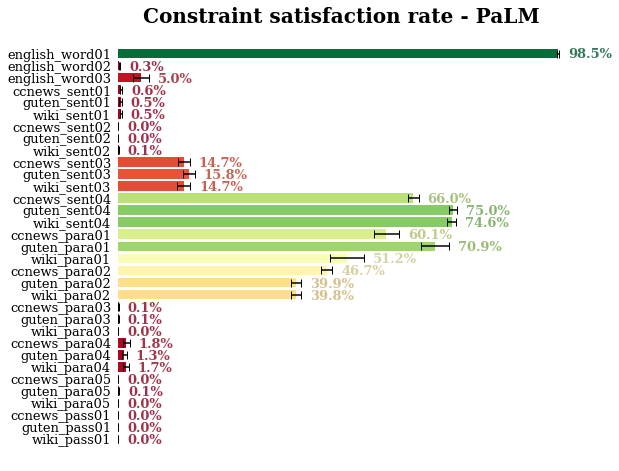

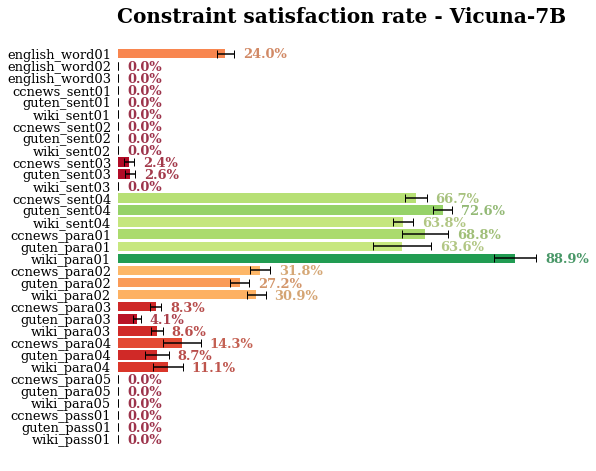

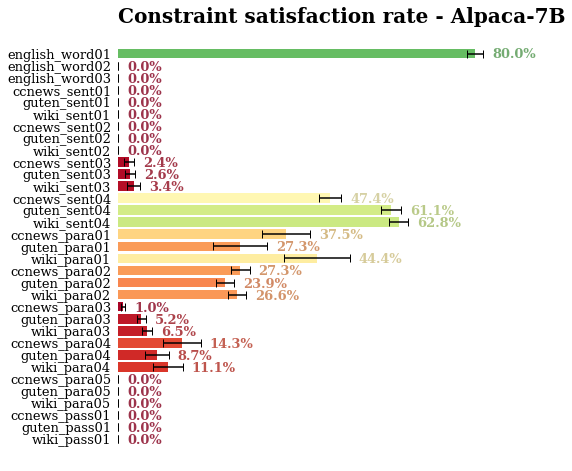

In [114]:
for tn in trial_names:
    acc = [accuracy_report[tn][k][0] for k in data_names]
    err = [accuracy_report[tn][k][1] for k in data_names]

    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    cmap = plt.cm.RdYlGn

    ax.barh(rename(data_names[::-1]), acc[::-1], 
            xerr=err[::-1],
            ecolor='black', capsize=4,
            color=cmap(np.array(acc[::-1])))
    for i, v in enumerate(acc[::-1]):
        # text_color = 'white' if np.mean(cmap(v)) < 0.5 else 'black'
        # bbox_props = dict(boxstyle='round,pad=0.1', 
        #                   fc=cmap(v), ec='black', lw=1)
        # ax.text(v + 0.02 + err[::-1][i], i, "{:.1f}%".format(100*v), va='center', weight='bold',
        #         color=text_color, bbox=bbox_props,fontsize=11)
        ax.text(v + 0.02 + err[::-1][i], i-0.1, "{:.1f}%".format(100*v), 
                va='center', 
                weight='bold',
                color=0.8*cmap(np.array(acc[::-1]))[i], font='Serif', fontsize=13)

    plt.box(False)
    plt.tick_params(left=False, bottom=False, labelbottom=False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    ax.set_title(f'Constraint satisfaction rate - {model_prefix[tn]}', fontweight='bold', fontsize=20, font='Serif')
    plt.yticks(font='Serif', fontsize=13)
    ax.set_xlim([0,1])

    plt.savefig(f'figures/{tn}-accuracy.pdf', bbox_inches='tight')

In [64]:
grouped_accuracy_report = {}
for tn in trial_names:
    grouped_accuracy_report[tn] = {k: accuracy_and_se(flatten_list([e[tn+"-all_check_result"] for e in grouped_data[k]])) 
                                   for k in grouped_data_names}

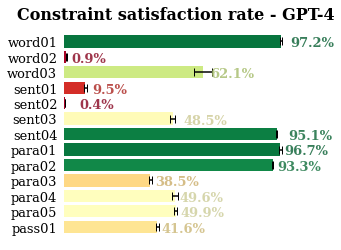

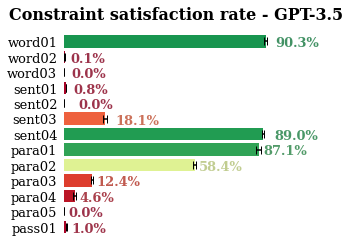

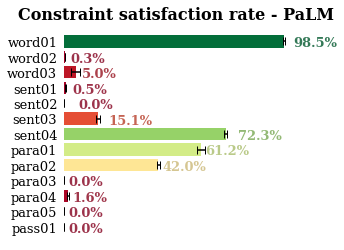

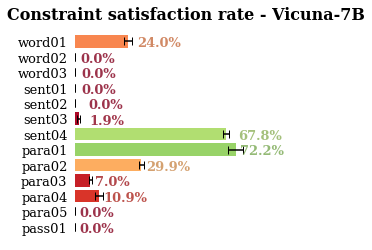

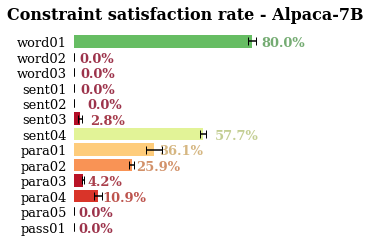

In [113]:
for tn in trial_names:
    grouped_acc = [grouped_accuracy_report[tn][k][0] for k in grouped_data_names]
    grouped_err = [grouped_accuracy_report[tn][k][1] for k in grouped_data_names]

    fig, ax = plt.subplots(1, 1, figsize=(4,4))

    cmap = plt.cm.RdYlGn

    ax.barh(rename(grouped_data_names[::-1]), grouped_acc[::-1], 
            xerr=grouped_err[::-1],
            ecolor='black', capsize=4,
            color=cmap(np.array(grouped_acc[::-1])))
    # for i, v in enumerate(grouped_acc[::-1]):
    #     text_color = 'white' if np.mean(cmap(v)) < 0.5 else 'black'
    #     bbox_props = dict(boxstyle='round,pad=0.1', 
    #                       fc=cmap(v), ec='black', lw=1)
    #     ax.text(v + 0.02 + grouped_err[::-1][i], i, "{:.1f}%".format(100*v), va='center', weight='bold',
    #             color=text_color, bbox=bbox_props, fontsize=14)
    for i, v in enumerate(grouped_acc[::-1]):
        # text_color = 'white' if np.mean(cmap(v)) < 0.5 else 'black'
        # bbox_props = dict(boxstyle='round,pad=0.1', 
        #                   fc=cmap(v), ec='black', lw=1)
        # ax.text(v + 0.02 + err[::-1][i], i, "{:.1f}%".format(100*v), va='center', weight='bold',
        #         color=text_color, bbox=bbox_props,fontsize=11)
        ax.text(v + 0.02 + err[::-1][i], i-0.1, "{:.1f}%".format(100*v), 
                va='center', 
                weight='bold',
                color=0.8*cmap(np.array(grouped_acc[::-1]))[i], font='Serif', fontsize=13)

    plt.box(False)
    plt.tick_params(left=False, bottom=False, labelbottom=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(f'Constraint satisfaction rate - {model_prefix[tn]}', fontweight='bold', fontsize=16, font='Serif')
    plt.yticks(font='Serif', fontsize=13)
    ax.set_xlim([0,1])

    plt.savefig(f'figures/{tn}-accuracy-grouped.pdf', bbox_inches='tight')

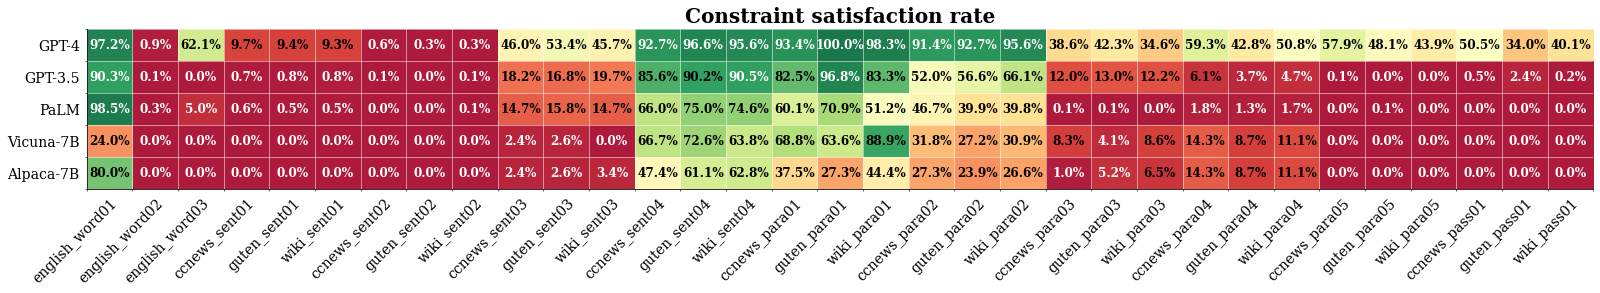

In [92]:
acc_values = np.zeros((len(trial_names), len(data_names)))

# Populate the accuracy values array
for i, tn in enumerate(trial_names):
    acc = [accuracy_report[tn][k][0] for k in data_names]
    acc_values[i] = acc

# Create the heat map
fig, ax = plt.subplots(figsize=(27, 8))
cmap = plt.cm.RdYlGn
im = ax.imshow(acc_values, cmap=cmap, aspect=0.7, alpha=0.9)

# Customize the heat map
ax.set_xticks(np.arange(len(data_names)))
ax.set_yticks(np.arange(len(trial_names)))
ax.set_xticklabels(rename(data_names), fontsize=16)
ax.set_yticklabels([model_prefix[tn] for tn in trial_names], fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Constraint satisfaction rate", fontweight="bold", fontsize=20, font='Serif')

# Add value annotations to the heat map
for i in range(len(trial_names)):
    for j in range(len(data_names)):
        text_color = "white" if np.mean(cmap(acc_values[i][j])) < 0.5 else "black"
        ax.text(j, i, f"{100*acc_values[i][j]:.1f}%", ha="center", va="center", color=text_color, 
                        fontweight='bold', fontsize=12, font='Serif')

# Hide the spines and ticks
ax.spines[["top", "right"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_xticks(np.arange(len(data_names) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(trial_names) + 1) - 0.5, minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
plt.yticks(font='Serif', fontsize=14)
plt.xticks(font='Serif', fontsize=14)

plt.savefig(f'figures/accuracy-heatmap.pdf', bbox_inches='tight')

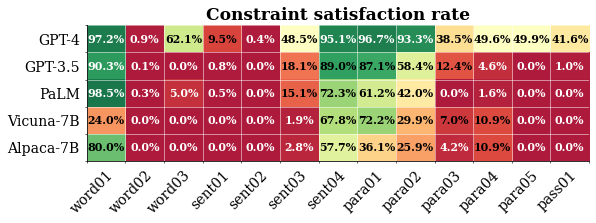

In [95]:
grouped_acc_values = np.zeros((len(trial_names), len(grouped_data_names)))

# Populate the accuracy values array
for i, tn in enumerate(trial_names):
    acc = [grouped_accuracy_report[tn][k][0] for k in grouped_data_names]
    grouped_acc_values[i] = acc

# Create the heat map
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.cm.RdYlGn
im = ax.imshow(grouped_acc_values, cmap=cmap, aspect=0.7, alpha=0.9)

# Customize the heat map
ax.set_xticks(np.arange(len(grouped_data_names)))
ax.set_yticks(np.arange(len(trial_names)))
ax.set_xticklabels(rename(grouped_data_names), fontsize=14)
ax.set_yticklabels([model_prefix[tn] for tn in trial_names], fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Constraint satisfaction rate", fontweight="bold", fontsize=17, font='Serif')

# Add value annotations to the heat map
for i in range(len(trial_names)):
    for j in range(len(grouped_data_names)):
        text_color = "white" if np.mean(cmap(grouped_acc_values[i][j])) < 0.5 else "black"
        ax.text(j, i, f"{100*grouped_acc_values[i][j]:.1f}%", ha="center", va="center", 
                color=text_color, fontweight='bold', fontsize=11, font='Serif')

# Hide the spines and ticks
ax.spines[["top", "right"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_xticks(np.arange(len(grouped_data_names) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(trial_names) + 1) - 0.5, minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
plt.yticks(font='Serif', fontsize=14)
plt.xticks(font='Serif', fontsize=14)

plt.savefig(f'figures/grouped-accuracy-heatmap.pdf', bbox_inches='tight')

### Model Comparison

In [96]:
aggregated_model_acc = {}
aggregated_model_err = {}
for tn in trial_names:
    aggregated_model_acc[tn] = np.average([grouped_accuracy_report[tn][k][0] for k in grouped_data_names], 
                                           weights=grouped_data_sizes)
    aggregated_model_err[tn] = sum([grouped_accuracy_report[tn][k][2] for k in grouped_data_names])
for tn in trial_names:
    accuracy = aggregated_model_acc[tn]
    num = aggregated_model_err[tn]
    aggregated_model_err[tn] = np.sqrt((accuracy * (1 - accuracy)) / num)

In [97]:
selected_models = list(aggregated_model_acc.keys())
selected_models

['zeroshot-gpt4',
 'zeroshot-gpt3.5',
 'zeroshot-palm',
 'zeroshot-vicuna7b',
 'zeroshot-alpaca7b']

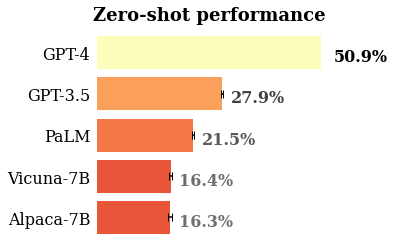

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# cmap = plt.cm.Greys
cmap = plt.cm.RdYlGn

scores = [aggregated_model_acc[m] for m in selected_models]
errs = [aggregated_model_err[m] for m in selected_models]

ax.barh([model_prefix[m] for m in selected_models[::-1]], 
        scores[::-1], 
        xerr=errs[::-1],
        ecolor='black', capsize=4,
        color=cmap(np.array(scores[::-1])))
for i, v in enumerate(scores[::-1]):
    # text_color = 'white' if np.mean(v) < 0.2 else 'black'
    # bbox_props = dict(boxstyle='round,pad=0.1', 
    #                   fc=cmap(v), ec='black', lw=1)
    # ax.text(v + 0.02 + grouped_err[::-1][i], i, "{:.1f}%".format(100*v), va='center', weight='bold',
    #         color=text_color, bbox=bbox_props, fontsize=14)
    ax.text(v + 0.02 + err[::-1][i], i-0.1, "{:.1f}%".format(100*v), 
                va='center', 
                weight='bold',
                color='k', alpha=1.4*np.sqrt(scores[::-1][i]), font='Serif', fontsize=16)

plt.box(False)
plt.tick_params(left=False, bottom=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Zero-shot performance', fontweight='bold', fontsize=18, font='Serif')
ax.set_xlim([0,0.5])
plt.yticks(font='Serif', fontsize=16)

plt.savefig('figures/overall-model-comparison.pdf', bbox_inches='tight')

### Position Effects

In [126]:
selected_constraints = ['c02', 'c05', 'c08', 'c03', 'c12', 'c14']
for cn in selected_constraints:
    print(grouped_data[cn][0]['prompt'], "\n")

Please generate a word:
1) with exactly 12 characters;
2) with the 4th, 8th, 11th characters to be 'o', 's', 'r' respectively. 

Please generate a sentence:
1) with exactly 17 words;
2) with the 4th, 8th, 11th words to be 'aids', 'positioners', 'nests' respectively. 

Please generate a paragraph with all sentences having the 1st word to be 'He'. 

Please generate a word:
1) with exactly 11 characters;
2) with the last character to be 'x'. 

Please generate a paragraph:
1) with exactly 3 sentences;
2) with sentences having the last word to be 'Peninsula', 'conversation', 'anonymity', respectively. 

Please generate a passage:
1) with paragraphs having the last sentence to be 'Windows 10 Pro for Workstations will be delivered as part of our Fall Creators Update, available this fall,” said Microsoft’s Partner Group Manager of the Windows & Devices Group at Microsoft', 'ReFS has “cloud-grade resiliency for data on fault-tolerant storage spaces and manages very large volumes with ease.” Thi

In [127]:
selected_constraints_anno = ['i-th char', 'i-th word', 'first word', 'last char', 'last word', 'last sent']

In [128]:
rename(selected_constraints)

['word02', 'sent02', 'para01', 'word03', 'para05', 'pass01']

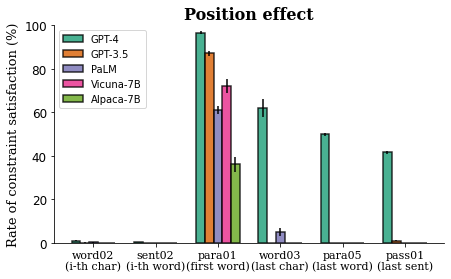

In [151]:
import matplotlib.patches as patches

grouped_accs = []
grouped_errs = []

for tn in trial_names:
    grouped_acc = [grouped_accuracy_report[tn][k][0] for k in selected_constraints]
    grouped_err = [grouped_accuracy_report[tn][k][1] for k in selected_constraints]
    grouped_accs.append(grouped_acc)
    grouped_errs.append(grouped_err)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

cmap = plt.cm.get_cmap('Dark2')
num_bars = len(selected_models)
bar_width = 0.14  # Increased width for more isolation
group_width = bar_width * num_bars
index = np.arange(len(selected_constraints))
opacity = 0.8

for i in range(num_bars):
    ax.bar(index + (i - (num_bars - 1) / 2) * bar_width, 100*np.array(grouped_accs[i]),
           yerr=100 * np.array(grouped_errs[i]),
           width=bar_width, alpha=opacity,
           color=cmap(i),
           label=model_prefix[selected_models[i]],
           linewidth=1.5,
           edgecolor='black')

# plt.xlabel('Selected constraints')
plt.ylabel('Rate of constraint satisfaction (%)', font='Serif', fontsize=13)
plt.title('Position effect', fontweight='bold', font='Serif', fontsize=16)
plt.xticks(index, rename([sc + "\n(" + selected_constraints_anno[i] + ")" 
                          for i, sc in enumerate(selected_constraints)]))  # Adjusted x-axis positioning
plt.legend(loc='upper left')
plt.ylim([0, 100])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(font='Serif', fontsize=11)
plt.tick_params(axis='y', labelsize=12)

plt.savefig('figures/position-effect.pdf', bbox_inches='tight')

### Counting Level Effects

In [152]:
selected_constraints = ['c01', 'c04', 'c06a', 'c11', 'c10']
selected_constraints_anno = ['cnt(char in word) ≥ a', 
                             'cnt(char in sentence) = a', 
                             'cnt(char in word) ≤ a &\ncnt(word in sent) ≥ b', 
                             'cnt(word in sent) ≥ a &\ncnt(sent in para) ≥ b', 
                             'a ≤ cnt(word in sent) ≤ b &\ncnt(sent in para) = c']
for cn in selected_constraints:
    print(grouped_data[cn][0]['prompt'], "\n")

Please generate a word with at least 11 characters. 

Please generate a sentence with exactly 82 characters. Include whitespace into your character count. 

Please generate a sentence:
1) with at least 20 words;
2) with all words having at most 6 characters. 

Please generate a paragraph:
1) with at least 3 sentences;
2) with all sentences having at least 19 words. 

Please generate a paragraph:
1) with exactly 3 sentences;
2) with all sentences having at least 12 words;
3) with all sentences having at most 18 words. 



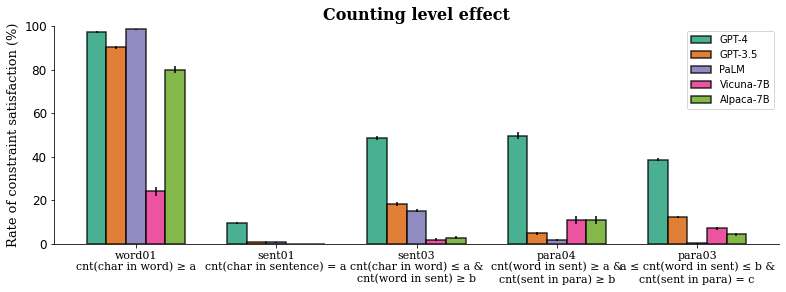

In [161]:
import matplotlib.patches as patches

grouped_accs = []
grouped_errs = []

for tn in trial_names:
    grouped_acc = [grouped_accuracy_report[tn][k][0] for k in selected_constraints]
    grouped_err = [grouped_accuracy_report[tn][k][1] for k in selected_constraints]
    grouped_accs.append(grouped_acc)
    grouped_errs.append(grouped_err)

fig, ax = plt.subplots(1, 1, figsize=(13, 4))

cmap = plt.cm.get_cmap('Dark2')
num_bars = len(selected_models)
bar_width = 0.14  # Increased width for more isolation
group_width = bar_width * num_bars
index = np.arange(len(selected_constraints))
opacity = 0.8

for i in range(num_bars):
    ax.bar(index + (i - (num_bars - 1) / 2) * bar_width, 100 * np.array(grouped_accs[i]),
           yerr=100 * np.array(grouped_errs[i]),
           width=bar_width, alpha=opacity,
           color=cmap(i),
           label=model_prefix[selected_models[i]],
           linewidth=1.5,
           edgecolor='black')

# plt.xlabel('Selected constraints', fontweight='bold')
plt.ylabel('Rate of constraint satisfaction (%)', font='Serif', fontsize=13)
plt.title('Counting level effect', fontweight='bold', font='Serif', fontsize=16)
plt.xticks(index, rename([sc + "\n" + selected_constraints_anno[i]
                          for i, sc in enumerate(selected_constraints)]))  # Adjusted x-axis positioning
plt.legend(loc='upper right')
plt.ylim([0, 100])
plt.xticks(font='Serif', fontsize=11)
plt.tick_params(axis='y', labelsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/count-level-effect.pdf', bbox_inches='tight')

### Pass@k rate

In [162]:
pass_k_data = all_data.copy()
for tn in trial_names:
    for k in data_names:
        grouped_k = k.split('_')[1]
        for eid, example in enumerate(pass_k_data[k]):
            c = example['constraint']
            sanity_check(k, c, example)

            # load multiple trail results
            try:
                all_text = list(prompt2text[tn][:, 1][
                                prompt2text[tn][:, 0] == example[promt_types[tn]]
                            ].reshape(-1))
                all_text = [x for x in all_text if x is not None]
                assert len(all_text) > 0
                all_res = [value_check(k, c, example, text) for text in all_text]
                pass_k_data[k][eid][tn+"-all_text"] = all_text
                pass_k_data[k][eid][tn+"-all_check_result"] = all_res
                for n_pass in range(1, len(all_res)+1):
                    pass_k_data[k][eid][tn+f"-pass@{n_pass}_results"] = any(all_res[:n_pass])
            except:
                # missing
                print("No text - ", tn, k, f"\nprompt:\n{example[promt_types[tn]]}\n\n")
                pass_k_data[k][eid][tn+"-all_text"] = []
                pass_k_data[k][eid][tn+"-all_check_result"] = []

No text -  zeroshot-palm ccnews_c05 
prompt:
Please generate a sentence:
1) with exactly 19 words;
2) with the 4th, 8th, 11th words to be 'suspect', 'home', 'hospital' respectively.


No text -  zeroshot-palm guten_c05 
prompt:
Please generate a sentence:
1) with exactly 11 words;
2) with the 4th, 8th, 11th words to be 'his', 'on', 'sore' respectively.


No text -  zeroshot-palm ccnews_c07 
prompt:
Please generate a sentence containing the word 'charged', 'been', 'Father'.


No text -  zeroshot-palm guten_c12 
prompt:
Please generate a paragraph:
1) with exactly 4 sentences;
2) with sentences having the last word to be 'walk', 'tumbling', 'another', 'lunatic', respectively.


No text -  zeroshot-palm ccnews_c14 
prompt:
Please generate a passage:
1) with paragraphs having the last sentence to be 'As you discovered in the above section, mice reproduce quickly and your problem can escalate over the course of months', 'Their urine can cause allergies in children, they can transmit human d

In [163]:
grouped_pass_k_data = {k: [] for k in grouped_data_names}

for k in data_names:
    grouped_pass_k_data[k.split("_")[1]] += pass_k_data[k]

In [164]:
selected_models = list(trial_names)[:2]
selected_models

['zeroshot-gpt4', 'zeroshot-gpt3.5']

In [165]:
grouped_pass_k_accuracy_report = {k: {} for k in range(1,21)}

for tn in selected_models:
    for pass_n in range(1, 21):
        grouped_pass_k_accuracy_report[pass_n][tn] = {k: accuracy_and_se(flatten_list([e[tn+f"-pass@{pass_n}_results"] 
                                                                                       for e in grouped_pass_k_data[k]])) 
                                              for k in grouped_data_names}

In [166]:
aggregated_model_pass_k_acc = {k: {} for k in range(1,21)}
aggregated_model_pass_k_err = {k: {} for k in range(1,21)}

for tn in selected_models:
    for pass_n in range(1, 21):
        aggregated_model_pass_k_acc[pass_n][tn] = np.average([grouped_pass_k_accuracy_report[pass_n][tn][k][0] for k in grouped_data_names], 
                                                              weights=grouped_data_sizes)
        aggregated_model_pass_k_err[pass_n][tn] = sum([grouped_pass_k_accuracy_report[pass_n][tn][k][2] for k in grouped_data_names])

for tn in selected_models:
    for pass_n in range(1, 21):
        accuracy = aggregated_model_pass_k_acc[pass_n][tn]
        num = aggregated_model_pass_k_err[pass_n][tn]
        aggregated_model_pass_k_err[pass_n][tn] = np.sqrt((accuracy * (1 - accuracy)) / num)

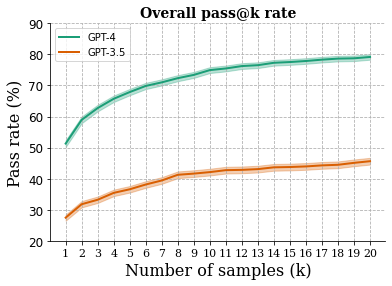

In [174]:
# Define the range of `pass_n` values from 1 to 20
pass_n_values = range(1, 21)

# Create empty lists to store accuracy and error values for each tn
accuracy_values = {tn: [] for tn in selected_models}
error_values = {tn: [] for tn in selected_models}

# Populate the accuracy and error lists for each tn
for tn in selected_models:
    for pass_n in pass_n_values:
        accuracy_values[tn].append(aggregated_model_pass_k_acc[pass_n][tn])
        error_values[tn].append(aggregated_model_pass_k_err[pass_n][tn])

# Convert the lists to numpy arrays
accuracy_values = {tn: np.array(acc_values) for tn, acc_values in accuracy_values.items()}
error_values = {tn: np.array(err_values) for tn, err_values in error_values.items()}

# Plot the line graph with shaded error for each tn
cmap = plt.cm.get_cmap('Dark2')
for i, tn in enumerate(selected_models):
    plt.plot(pass_n_values, 100 * np.array(accuracy_values[tn]), linewidth=2, label=model_prefix[tn], color=cmap(i))
    plt.fill_between(pass_n_values, 100 * np.array(accuracy_values[tn]) - 100*error_values[tn], 
                     100 * accuracy_values[tn] + 100 * error_values[tn], color=cmap(i), alpha=0.3)

# Set the x-axis ticks
plt.xticks(pass_n_values)
plt.title('Overall pass@k rate', fontweight='bold', font='Serif', fontsize=14)
plt.ylabel('Pass rate (%)', font='Serif', fontsize=16)
plt.xlabel('Number of samples (k)', font='Serif', fontsize=16)

plt.legend(loc='best')
plt.ylim([20, 90])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(font='Serif', fontsize=11)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='dashed')

plt.savefig('figures/pass@k.pdf', bbox_inches='tight')

### Word Validity

In [175]:
from pathlib import Path
wordlist = set(Path("data/english3.txt").read_text().split("\n"))
wordlist = wordlist.union({
             "supercalifragilisticexpialidocious", 
             "pneumonoultramicroscopicsilicovolcanoconiosis",
             "antidisestablishmentarianism",
             "pseudopseudohypoparathyroidism",
             "extraterrestrializationism",
             "acceleratrix",
             "circumlocutrix",
             "procrastinatrix"})
wordlist.remove("")

def is_english_word(word, wordslist=wordlist):
    return (word.lower() in wordlist) or (word in wordlist)

def validity_and_se(_words):
    num_predictions = len(_words)
    check_res = [is_english_word(w) for w in _words]
    num_correct = sum(check_res)
    accuracy = num_correct / num_predictions
    standard_error = np.sqrt((accuracy * (1 - accuracy)) / num_predictions)
    
    return accuracy, standard_error, num_predictions

In [176]:
selected_models = list(aggregated_model_acc.keys())
selected_models

['zeroshot-gpt4',
 'zeroshot-gpt3.5',
 'zeroshot-palm',
 'zeroshot-vicuna7b',
 'zeroshot-alpaca7b']

In [177]:
word_task_names = grouped_data_names[:3]
word_task_names

['c01', 'c02', 'c03']

In [178]:
word_task_anno = ['cnt', 'cnt + i-th pos', 'cnt + last pos']

In [179]:
word_validity_report = {}
for tn in trial_names:
    word_validity_report[tn] = {k: validity_and_se(flatten_list([e[tn+"-all_text"] for e in grouped_data[k]])) for k in word_task_names}

In [180]:
word_validity_report

{'zeroshot-gpt4': {'c01': (0.963, 0.004220841148396847, 2000),
  'c02': (0.03469387755102041, 0.004133623479114831, 1960),
  'c03': (0.0, 0.0, 140)},
 'zeroshot-gpt3.5': {'c01': (0.9675, 0.00396508196636589, 2000),
  'c02': (0.4377551020408163, 0.011205992672428253, 1960),
  'c03': (0.0, 0.0, 140)},
 'zeroshot-palm': {'c01': (0.724, 0.009995599031573845, 2000),
  'c02': (0.0933673469387755, 0.006571812312723811, 1960),
  'c03': (0.28776978417266186, 0.03839948436122262, 139)},
 'zeroshot-vicuna7b': {'c01': (0.92, 0.012132600710482479, 500),
  'c02': (0.10204081632653061, 0.013674681515520202, 490),
  'c03': (0.0, 0.0, 35)},
 'zeroshot-alpaca7b': {'c01': (0.0, 0.0, 500),
  'c02': (0.061224489795918366, 0.01083042310262782, 490),
  'c03': (0.0, 0.0, 35)}}

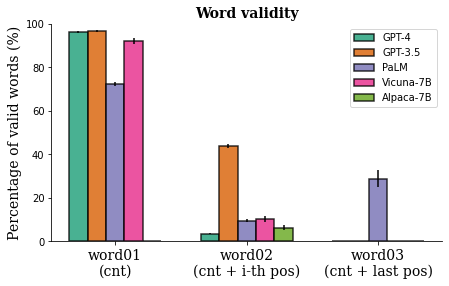

In [184]:
import matplotlib.patches as patches

grouped_accs = []
grouped_errs = []

for tn in trial_names:
    grouped_acc = [word_validity_report[tn][k][0] for k in word_task_names]
    grouped_err = [word_validity_report[tn][k][1] for k in word_task_names]
    grouped_accs.append(grouped_acc)
    grouped_errs.append(grouped_err)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

cmap = plt.cm.get_cmap('Dark2')
num_bars = len(selected_models)
bar_width = 0.14  # Increased width for more isolation
group_width = bar_width * num_bars
index = np.arange(len(word_task_names))
opacity = 0.8

for i in range(num_bars):
    ax.bar(index + (i - (num_bars - 1) / 2) * bar_width, 100*np.array(grouped_accs[i]),
           yerr=100 * np.array(grouped_errs[i]),
           width=bar_width, alpha=opacity,
           color=cmap(i),
           label=model_prefix[selected_models[i]],
           linewidth=1.5,
           edgecolor='black')

# plt.xlabel('Selected constraints')
plt.ylabel('Percentage of valid words (%)', font='Serif', fontsize=14)
plt.title('Word validity', fontweight='bold', font='Serif', fontsize=14)
plt.xticks(index, rename([sc + "\n(" + word_task_anno[i] + ")" 
                          for i, sc in enumerate(word_task_names)]))  # Adjusted x-axis positioning
plt.legend(loc='upper right')
plt.xticks(font='Serif', fontsize=14)
plt.ylim([0, 100])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/word-validity.pdf', bbox_inches='tight')

In [185]:
# flatten_list([e["zeroshot-gpt4"+"-all_text"] for e in grouped_data[word_task_names[1]]])

### Coherence Rating

In [43]:
from utils.coherency_judge import coherency_score
import nest_asyncio
nest_asyncio.apply()

In [44]:
def coherence_and_se(_pass, n=3):
    num_predictions = len(_pass)
    check_res = coherency_score(_pass, n=3)
    coherence = np.nanmean(check_res)
    standard_error = np.nanstd(check_res) / num_predictions
    
    return coherence, standard_error, num_predictions

In [45]:
pass_task_names = data_names[-3:]

In [46]:
pass_task_names

['ccnews_c14', 'guten_c14', 'wiki_c14']

In [60]:
###
# results are obtainted by running `python eval_conherence.py`
###

with open("logs/pass_coherence_report.json", "rb") as f:
    pass_coherence_report = json.load(f)
    
with open("logs/ground_truth_pass_coherence_report.json", "rb") as f:
    ground_truth_pass_coherence_report = json.load(f)

In [61]:
pass_coherence_report, ground_truth_pass_coherence_report

({'zeroshot-gpt4': {'ccnews_c14': [7.5, 0.14725377234348788, 14],
   'guten_c14': [7.271317829457364, 0.05590641475994057, 43],
   'wiki_c14': [8.0, 0.08622285204889307, 26]},
  'zeroshot-gpt3.5': {'ccnews_c14': [7.357142857142857,
    0.1803122147660438,
    14],
   'guten_c14': [6.333333333333333, 0.05624893099863439, 43],
   'wiki_c14': [7.230769230769231, 0.10648147795765092, 26]},
  'zeroshot-palm': {'ccnews_c14': [6.5, 0.15212297465179156, 14],
   'guten_c14': [4.852713178294573, 0.06224723079272524, 43],
   'wiki_c14': [6.923076923076923, 0.08595171033333698, 26]},
  'zeroshot-vicuna7b': {'ccnews_c14': [5.285714285714286,
    0.22870197923828894,
    14],
   'guten_c14': [5.3565891472868215, 0.06942397575715144, 43],
   'wiki_c14': [6.589743589743589, 0.10015083023464441, 26]},
  'zeroshot-alpaca7b': {'ccnews_c14': [5.833333333333333,
    0.18305040453188662,
    14],
   'guten_c14': [3.9689922480620154, 0.05877161256744177, 43],
   'wiki_c14': [6.666666666666667, 0.074840311123

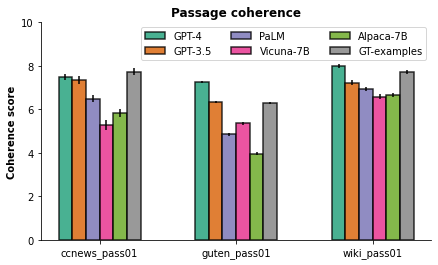

In [69]:
import matplotlib.patches as patches

grouped_accs = []
grouped_errs = []

for tn in list(trial_names) + ['gt']:
    if tn != 'gt':
        grouped_acc = [pass_coherence_report[tn][k][0] for k in pass_task_names]
        grouped_err = [pass_coherence_report[tn][k][1] for k in pass_task_names]
        grouped_accs.append(grouped_acc)
        grouped_errs.append(grouped_err)
    else:
        grouped_acc = [ground_truth_pass_coherence_report[tn][k][0] for k in pass_task_names]
        grouped_err = [ground_truth_pass_coherence_report[tn][k][1] for k in pass_task_names]
        grouped_accs.append(grouped_acc)
        grouped_errs.append(grouped_err)
        

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

cmap = plt.cm.get_cmap('Dark2')
num_bars = len(selected_models) + 1
bar_width = 0.1  # Increased width for more isolation
group_width = bar_width * num_bars
index = np.arange(len(word_task_names))
opacity = 0.8

for i in range(num_bars):
    ax.bar(index + (i - (num_bars - 1) / 2) * bar_width, np.array(grouped_accs[i]),
           yerr=np.array(grouped_errs[i]),
           width=bar_width, alpha=opacity,
           color=cmap(i) if i < len(selected_models) else 'gray',
           label=model_prefix[selected_models[i]] if i < len(selected_models) else 'GT-examples',
           linewidth=1.5,
           edgecolor='black')

# plt.xlabel('Selected constraints')
plt.ylabel('Coherence score', fontweight='bold')
plt.title('Passage coherence', fontweight='bold')
plt.xticks(index, rename([sc for i, sc in enumerate(pass_task_names)]))  # Adjusted x-axis positioning
plt.legend(loc='best', ncol=3)
plt.ylim([0, 10])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/pass-coherence.pdf', bbox_inches='tight')